In [1]:
import sys
sys.path.append("../")
from util.image import show_image_with_label
from dataset.coco import DataSet
from generator import Generator
from model import get_model,load
from loss import SSDLoss80,SSDLoss,SSDLossTest,SSDLossSplit
#from loss1 import SSDLoss as TempLoss

from callbacks.l2callback import L2LossCallback
#from util.image import show_image_with_label,show_result

import numpy as np
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger,ReduceLROnPlateau
import cv2
import time
import tensorflow as tf
from layers.newsuppression import my_nms
import os
from tensorflow.keras.mixed_precision import experimental as mixed_precision
#from tg1 import Generator  as newGenerator
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config = config)

In [3]:
policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_policy(policy)

Some of your GPUs may run slowly with dtype policy mixed_float16 because they do not all have compute capability of at least 7.0. Your GPUs:
  NVIDIA A100-PCIE-40GB, compute capability 8.0
  Tesla P4, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [3]:
ratio,ratio1,ratio2 = [1/6.55,6.55],[-1,1],[-1,10]
s1,s2,s3 = 20,32,40
size = 320
t = 1
a1 = int(size/8)
a2 = int(size/16)
a3 = int(size/32)
a4 = int(size/64)
a5 = int(size/128)
config = {
    "image_size":(size,size),
    "blength":2,
    "info" : [
    {"shape":[a1,a1],"starts":3.5, "steps":8,  "scale":[s1,2*s1],  "boxes":[t*s1,t*s1],  "ratio":ratio}, 
    {"shape":[a1,a1],"starts":3.5, "steps":8,  "scale":[s2,2*s2],  "boxes":[t*s2,t*s2],  "ratio":ratio},
   # {"shape":[a1,a1],"starts":3.5, "steps":8,  "scale":[s3,2*s3],  "boxes":[t*s3,t*s3],  "ratio":ratio},
       
    {"shape":[a2,a2],"starts":7.5, "steps":16, "scale":[2*s1,4*s1], "boxes":[t*2*s1,t*2*s1],  "ratio":ratio},
    {"shape":[a2,a2],"starts":7.5, "steps":16, "scale":[2*s2,4*s2], "boxes":[t*2*s2,t*2*s2],  "ratio":ratio},
 #   {"shape":[a2,a2],"starts":7.5, "steps":16, "scale":[2*s3,4*s3], "boxes":[t*2*s3,t*2*s3],  "ratio":ratio},
        
    {"shape":[a3,a3],"starts":15.5,"steps":32, "scale":[4*s1,8*s1],"boxes":[t*4*s1,t*4*s1],  "ratio":ratio},
    {"shape":[a3,a3],"starts":15.5,"steps":32, "scale":[4*s2,8*s2],"boxes":[t*4*s2,t*4*s2],  "ratio":ratio}, 
#    {"shape":[a3,a3],"starts":15.5,"steps":32, "scale":[4*s3,8*s3],"boxes":[t*4*s3,t*4*s3],  "ratio":ratio}, 
        
    {"shape":[a4,a4],  "starts":31.5,"steps":64, "scale":[8*s1,16*s1],"boxes":[t*8*s1,t*8*s1],"ratio":ratio},
    {"shape":[a4,a4],  "starts":31.5,"steps":64, "scale":[8*s2,16*s2],"boxes":[8*s2,8*s2],"ratio":ratio},
   # {"shape":[a4,a4],  "starts":31.5,"steps":64, "scale":[8*s3,16*s3],"boxes":[8*s3,8*s3],"ratio":ratio},
        
  #  {"shape":[a5,a5],  "starts":63.5,"steps":128, "scale":[16*s1,32*s1],"boxes":[t*16*s1,t*16*s1],"ratio":ratio},
  #  {"shape":[a5,a5],  "starts":63.5,"steps":128, "scale":[16*s2,32*s2],"boxes":[16*s2,16*s2],"ratio":ratio},
        
  #  {"shape":[a5,a5],  "starts":63.5,"steps":128, "scale":[16*s1,32*s1],"boxes":[t*16*s1,t*16*s1],"ratio":ratio},
  
    ],
    "variances":np.array([0.1,0.1,0.2,0.2],dtype = np.float32),
    "l2_reg" :0.0002,
    "regression_type":"coarse",
    "kernel_initializer":"he_normal",#keras.initializers.normal(mean = 0.0,stddev= 0.01,seed= None),
    "load_images_into_memory":False,
    "verbose":True,
    "nclasses":81,
    "classes":['background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 
               'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 
               'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 
               'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 
               'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 
               'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 
               'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 
               'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 
               'teddy bear', 'hair drier', 'toothbrush'],

    "image_mean":np.array([123, 117, 104]),
    "include_classes":"all",
    "batch":32,
    "shuffle":True,
    "map_mode":"sample"
}
print(config["info"])

[{'shape': [40, 40], 'starts': 3.5, 'steps': 8, 'scale': [20, 40], 'boxes': [20, 20], 'ratio': [0.15267175572519084, 6.55]}, {'shape': [40, 40], 'starts': 3.5, 'steps': 8, 'scale': [32, 64], 'boxes': [32, 32], 'ratio': [0.15267175572519084, 6.55]}, {'shape': [20, 20], 'starts': 7.5, 'steps': 16, 'scale': [40, 80], 'boxes': [40, 40], 'ratio': [0.15267175572519084, 6.55]}, {'shape': [20, 20], 'starts': 7.5, 'steps': 16, 'scale': [64, 128], 'boxes': [64, 64], 'ratio': [0.15267175572519084, 6.55]}, {'shape': [10, 10], 'starts': 15.5, 'steps': 32, 'scale': [80, 160], 'boxes': [80, 80], 'ratio': [0.15267175572519084, 6.55]}, {'shape': [10, 10], 'starts': 15.5, 'steps': 32, 'scale': [128, 256], 'boxes': [128, 128], 'ratio': [0.15267175572519084, 6.55]}, {'shape': [5, 5], 'starts': 31.5, 'steps': 64, 'scale': [160, 320], 'boxes': [160, 160], 'ratio': [0.15267175572519084, 6.55]}, {'shape': [5, 5], 'starts': 31.5, 'steps': 64, 'scale': [256, 512], 'boxes': [256, 256], 'ratio': [0.15267175572519

In [12]:
coco_train = DataSet(config,
              ["/u40/xuz131/dataset/coco/train2017"],
                    ["/u40/xuz131/dataset/coco/annotations/instances_train2017.json"],True)

-------------------------
{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77

In [13]:
train_generator = Generator(config,coco_train,"train",32)
#train_generator = newGenerator(config,None,"train",32)
#train_getter = train_generator.generate()                                                          

[[3.5000000e+00 3.5000000e+00 2.0000000e+01 ... 2.0000000e+01
  1.5267175e-01 6.5500002e+00]
 [1.1500000e+01 3.5000000e+00 2.0000000e+01 ... 2.0000000e+01
  1.5267175e-01 6.5500002e+00]
 [1.9500000e+01 3.5000000e+00 2.0000000e+01 ... 2.0000000e+01
  1.5267175e-01 6.5500002e+00]
 ...
 [1.5950000e+02 2.8750000e+02 2.5600000e+02 ... 2.5600000e+02
  1.5267175e-01 6.5500002e+00]
 [2.2350000e+02 2.8750000e+02 2.5600000e+02 ... 2.5600000e+02
  1.5267175e-01 6.5500002e+00]
 [2.8750000e+02 2.8750000e+02 2.5600000e+02 ... 2.5600000e+02
  1.5267175e-01 6.5500002e+00]]


In [ ]:
start = time.time()
next(train_generator)
print(time.time()-start)

In [4]:
#train_model = get_model(config)
train_model,infer_model,eval_model= get_model(config)
#train_model,infer_model,eval_model= load(config)
#train_model = get_model(config)
train_model.summary()
#add_regularizer(train_model,0.0001)

--------------------------
std: 0.05892556509887896
--------------------------
std: 0.05103103630798288
--------------------------
std: 0.038273277230987154
--------------------------
std: 0.041666666666666664
--------------------------
std: 0.03608439182435161
--------------------------
std: 0.03608439182435161
--------------------------
std: 0.027063293868263706
--------------------------
std: 0.02551551815399144
--------------------------
std: 0.020833333333333332
--------------------------
std: 0.020833333333333332
--------------------------
std: 0.03125
--------------------------
std: 0.020833333333333332
--------------------------
std: 0.020833333333333332
--------------------------
std: 0.020833333333333332
--------------------------
std: 0.03125
--------------------------
std: 0.020833333333333332
--------------------------
std: 0.020833333333333332
--------------------------
std: 0.020833333333333332
--------------------------
std: 0.03125
--------------------------
std: 0.020

In [16]:
#train_model.load_weights("/u40/xuz131/program/coco/labelsmooth/weights/320/epoch-348_loss-3.6521.h5", by_name = True)
#train_model.load_weights("/u40/xuz131/pretrain/vgg_coco_320.h5", by_name = True)
#train_model.load_weights("/u40/xuz131/pretrain/768_wd_0.0001.h5",by_name=True)
train_model.load_weights("weights/temp/epoch-1200_loss-2.8496.h5", by_name = True)
#train_model.load_weights("/home/zhiwei/program/image100/weights/temp1/epoch-32_loss-0.7174_accuracy-0.9379_valacc-0.8269.h5", by_name = True,skip_mismatch = True)

In [34]:
def l2_loss(model):
    variable_list=[]
    for v in model.trainable_variables:
        if "kernel" in v.name:
            variable_list.append(tf.nn.l2_loss(v))
    return tf.add_n(variable_list)

In [47]:
l2_loss(train_model)

<tf.Tensor: shape=(), dtype=float32, numpy=3199.53>

In [17]:
for layer in train_model.layers:
    layer.trainable=False

In [22]:
target = train_model.predict(data[0])
SSDLoss(config).class_loss(data[1][0],target[0])
SSDLoss(config).regress_loss(data[1][1],target[1])

n_positives: tf.Tensor(728, shape=(), dtype=int32)
positive_loss: tf.Tensor(4782.995, shape=(), dtype=float32)
n_negative: tf.Tensor(2184, shape=(), dtype=int32)
negative loss: tf.Tensor(827.60614, shape=(), dtype=float32)
total loss: tf.Tensor(7.7068696, shape=(), dtype=float32)
class: tf.Tensor(7.7068696, shape=(), dtype=float32)
localization_loss: tf.Tensor(1050.2131, shape=(), dtype=float32)
localization_loss: tf.Tensor(1.4426005, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=1.4426005>

In [33]:
target = train_model.predict(data[0])
SSDLoss(config).class_loss(data[1][0],target[0])
SSDLoss(config).regress_loss(data[1][1],target[1])
print("--------------------")
TempLoss(config).class_loss(data[1][0],target[0])
TempLoss(config).regress_loss(data[1][1],target[1])

n_positives: tf.Tensor(744, shape=(), dtype=int32)
positive_loss: tf.Tensor(5412.9224, shape=(), dtype=float32)
n_negative: tf.Tensor(2232, shape=(), dtype=int32)
negative loss: tf.Tensor(757.7731, shape=(), dtype=float32)
total loss: tf.Tensor(8.293945, shape=(), dtype=float32)
class: tf.Tensor(8.293945, shape=(), dtype=float32)
localization_loss: tf.Tensor(1214.4365, shape=(), dtype=float32)
localization_loss: tf.Tensor(1.6323072, shape=(), dtype=float32)
--------------------
n_positives: tf.Tensor(744, shape=(), dtype=int32)
total_loss: tf.Tensor(8.557161, shape=(), dtype=float32)
localization_loss: tf.Tensor(1214.4365, shape=(), dtype=float32)
localization_loss: tf.Tensor(1.6323072, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=1.6323072>

In [ ]:
target = train_model.predict(data[0])
SSDLossSplit(config).class_loss(data[1][0],target[0])
SSDLossSplit(config).regress_loss(data[1][1],target[1])

In [ ]:
data = next(train_getter)
print(data[0].shape,data[1][0].shape,data[1][1].shape)

target = train_model.predict(data[0])
#SSDLoss(config).class_loss(data[1][0],target[0])
SSDLossTest(config).regress(data[1][1],target[1])
SSDLossTest(config).classifier(data[1][0],target[0])

In [ ]:
data = next(train_getter)
print(data[0].shape,data[1][0].shape,data[1][1].shape)

In [ ]:
target = train_model.predict(data[0])
print(target[0].shape,target[1].shape)

In [ ]:
total=0
for i in range(8):
    for j in range(6325):
        a,b,c,d = target[1][i,j]
        prediction = max(list(target[0][i][j][1:]))
        if prediction>0.05:
            total+=1
            if abs(a)>=3.5 or abs(b)>=3.5 or max(c,d)>=np.log(2)/0.2:
                print(a,b,c,d,prediction)
print(total)

In [ ]:
data = next(train_getter)
print(data[0].shape,data[1].shape)

target = train_model.predict(data[0])
SSDLoss(config).compute_loss(data[1],target)

In [ ]:
data = next(train_getter)
print(data[0].shape,data[1].shape)

target = train_model.predict(data[0])
SSDLoss80(config).compute_loss(data[1],target)

In [ ]:
test_getter = test_generator.generate()

In [ ]:
data = next(train_getter)
print(data[0].shape,data[1].shape)

target = train_model.predict(data[0])
SSDLoss(config).compute_loss(data[1],target)

In [ ]:
output = train_model.predict(data[0])

In [26]:
# Define model callbacks.

base = "weights/temp/"

def lr_schedule(epoch):
   # return 0.0000001
   # if epoch==0:
    #    return 0.0001
 #   if epoch<20:
 #       return 0.00005*(epoch+1)
    if epoch < 300:
        return 0.000001
    elif epoch < 350:
        return 0.001
    else:
        return 0.0001
    
#l2loss = L2LossCallback(config,train_model)

model_checkpoint = ModelCheckpoint(filepath=base+'epoch-{epoch:02d}_loss-{loss:.4f}.h5',
                                   monitor='loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='min',                                                                                                                                                                                                                                                                                                                                                                                                                                 
                                   period=4)
csv_logger = CSVLogger(filename=base+'training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

tensorboard = TensorBoard(log_dir=base+'logs',
                          histogram_freq=1,
                          batch_size=32, 
                          write_graph=False, 
                          write_grads=True)

callbacks = [
         #   l2loss,
          #  tensorboard,
         #   model_checkpoint,
          #   csv_logger,
             learning_rate_scheduler,
            # lr_reduce,
             terminate_on_nan]

In [27]:
#sgd = Adam(lr=0.001)

sgd = SGD(lr=0.001, momentum=0.9, decay=0, nesterov=False)
neg_pos_ratio = 4
if config["regression_type"]=="fine":
    myloss = SSDLoss80(config)
else:
    myloss = SSDLoss(config)
#ssdLoss = SSDLoss80()
#ssdLoss = SSDLoss(config)

train_model.compile(
    loss=[myloss.class_loss,myloss.regress_loss],
    optimizer=sgd
)

In [28]:
train_model.fit_generator(
        generator=test_generator,
        steps_per_epoch=100,
        epochs=100,
        verbose=1,
        callbacks=callbacks, 
      #  use_multiprocessing=True,
       # workers = 10,
        initial_epoch=0
    )

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
n_positives: Tensor("class_loss/strided_slice_5:0", shape=(), dtype=int32)
positive_loss: Tensor("class_loss/Sum_1:0", shape=(), dtype=float32)
n_negative: Tensor("class_loss/Minimum:0", shape=(), dtype=int32)
negative loss: Tensor("class_loss/cond/Identity:0", shape=(), dtype=float32)
total loss: Tensor("class_loss/truediv:0", shape=(), dtype=float32)
class: Tensor("class_loss/truediv_1:0", shape=(), dtype=float32)
localization_loss: Tensor("regress_loss/Sum_2:0", shape=(), dtype=float32)
localization_loss: Tensor("regress_loss/truediv:0", shape=(), dtype=float32)
n_positives: Tensor("class_loss/strided_slice_5:0", shape=(), dtype=int32)
positive_loss: Tensor("class_loss/Sum_1:0", shape=(), dtype=float32)
n_negative: Tensor("class_loss/Minimum:0", shape=(), dtype=int32)
negative loss: Tensor("class_loss/cond/Identity:0", shape=(), dtype=float32)
total loss: Tensor("class_loss/truediv:0", shape=(), dtype=f

100/100 [==============================] - 73s 732ms/step - loss: 3.5787 - classification_concatenate_loss: 2.0708 - regression_concatenate_loss: 0.9226
Epoch 32/100

Epoch 00032: LearningRateScheduler reducing learning rate to 1e-06.
100/100 [==============================] - 74s 737ms/step - loss: 3.5731 - classification_concatenate_loss: 2.0634 - regression_concatenate_loss: 0.9244
Epoch 33/100

Epoch 00033: LearningRateScheduler reducing learning rate to 1e-06.
100/100 [==============================] - 73s 732ms/step - loss: 3.5912 - classification_concatenate_loss: 2.0677 - regression_concatenate_loss: 0.9382
Epoch 34/100

Epoch 00034: LearningRateScheduler reducing learning rate to 1e-06.
100/100 [==============================] - 73s 732ms/step - loss: 3.6338 - classification_concatenate_loss: 2.1060 - regression_concatenate_loss: 0.9425
Epoch 35/100

Epoch 00035: LearningRateScheduler reducing learning rate to 1e-06.
100/100 [==============================] - 73s 730ms/step - 

100/100 [==============================] - 71s 710ms/step - loss: 3.5728 - classification_concatenate_loss: 2.0665 - regression_concatenate_loss: 0.9210
Epoch 67/100

Epoch 00067: LearningRateScheduler reducing learning rate to 1e-06.
100/100 [==============================] - 72s 718ms/step - loss: 3.6134 - classification_concatenate_loss: 2.0957 - regression_concatenate_loss: 0.9324
Epoch 68/100

Epoch 00068: LearningRateScheduler reducing learning rate to 1e-06.
100/100 [==============================] - 71s 713ms/step - loss: 3.5959 - classification_concatenate_loss: 2.0811 - regression_concatenate_loss: 0.9295
Epoch 69/100

Epoch 00069: LearningRateScheduler reducing learning rate to 1e-06.
100/100 [==============================] - 72s 715ms/step - loss: 3.6033 - classification_concatenate_loss: 2.0826 - regression_concatenate_loss: 0.9354
Epoch 70/100

Epoch 00070: LearningRateScheduler reducing learning rate to 1e-06.
100/100 [==============================] - 69s 685ms/step - 

In [ ]:
validation set : resize:
classification_concatenate_loss: 2.0463 - regression_concatenate_loss: 0.9123
validation set:  ssd aug
classification_concatenate_loss: 2.0924 - regression_concatenate_loss: 0.9342

In [ ]:
train_model.save_weights("freeze_backbone.h5")

In [6]:
coco_test = DataSet(config,
              ["/u40/xuz131/dataset/coco/val2017"],                           
                    ["/u40/xuz131/dataset/coco/annotations/instances_val2017.json"],True)

-------------------------
{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77

In [25]:
test_generator = Generator(config,coco_test,"train",32)

[[3.5000000e+00 3.5000000e+00 2.0000000e+01 ... 2.0000000e+01
  1.5267175e-01 6.5500002e+00]
 [1.1500000e+01 3.5000000e+00 2.0000000e+01 ... 2.0000000e+01
  1.5267175e-01 6.5500002e+00]
 [1.9500000e+01 3.5000000e+00 2.0000000e+01 ... 2.0000000e+01
  1.5267175e-01 6.5500002e+00]
 ...
 [1.5950000e+02 2.8750000e+02 2.5600000e+02 ... 2.5600000e+02
  1.5267175e-01 6.5500002e+00]
 [2.2350000e+02 2.8750000e+02 2.5600000e+02 ... 2.5600000e+02
  1.5267175e-01 6.5500002e+00]
 [2.8750000e+02 2.8750000e+02 2.5600000e+02 ... 2.5600000e+02
  1.5267175e-01 6.5500002e+00]]


In [36]:
image = show_image_with_label(test_generator,config)

[[2.       1.25    ]
 [2.       1.35    ]
 [2.       1.5     ]
 [1.5      2.      ]
 [2.       1.334375]
 [2.       1.159375]
 [1.5625   1.171875]
 [2.       1.5     ]
 [2.       1.334375]
 [2.       1.5     ]
 [1.5625   1.171875]
 [2.       1.403125]
 [1.328125 2.      ]
 [1.815625 2.      ]
 [2.       1.5     ]
 [1.334375 2.      ]
 [2.       1.125   ]
 [2.       2.      ]
 [2.       1.5     ]
 [2.       1.5     ]
 [2.       1.334375]
 [1.246875 2.      ]
 [2.       1.334375]
 [2.       1.325   ]
 [2.       1.3375  ]
 [2.       1.5     ]
 [2.       1.5     ]
 [2.       1.41875 ]
 [2.       1.5     ]
 [2.       1.375   ]
 [2.       1.33125 ]
 [2.       1.5     ]]


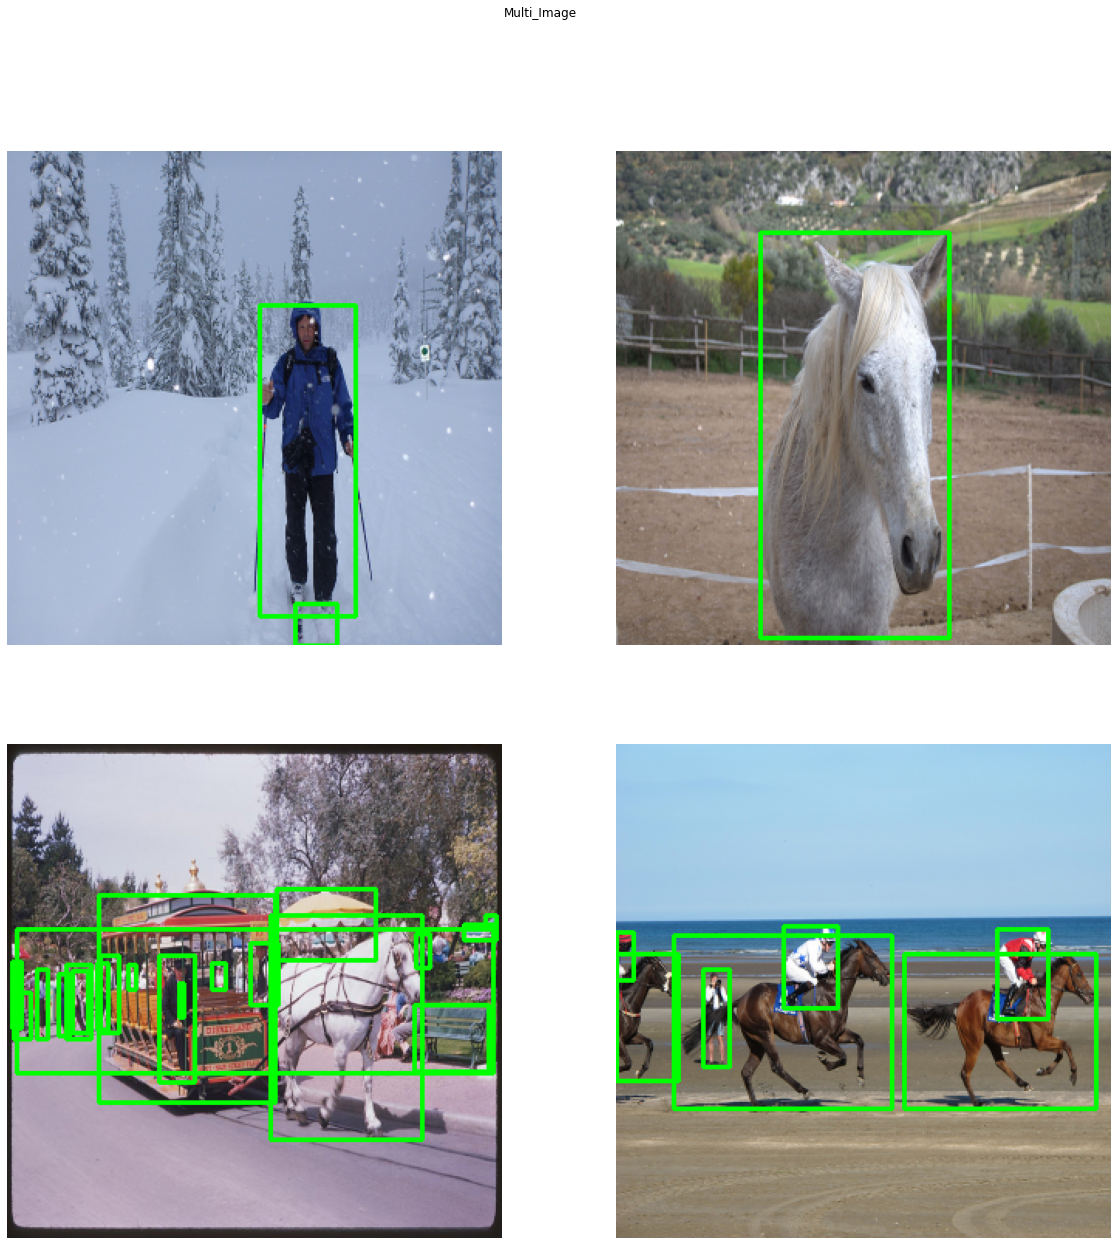

In [37]:
plt.figure(figsize=(20,20)) #设置窗口大小
plt.suptitle('Multi_Image') # 图片名称
for i in range(4):
    plt.subplot(2,2,i+1) 
    plt.imshow(image[-i-1])
    plt.axis('off')

In [53]:
temp = next(test_generator)

In [54]:
output = train_model.predict(temp[0])

In [55]:
output[-1][0].shape

(2, 2, 768)

In [56]:
def diff(left,right):
    a,b,c = left.shape
    dot_product = np.sum(left*right,axis = -1)
    left_length = np.sqrt(np.sum(left**2,axis = -1))
    right_length = np.sqrt(np.sum(right**2,axis = -1))
    result = dot_product/(left_length*right_length)
    print(np.sum(result)/(a*a))
    

In [26]:
def diff1(left,right):
    total = np.sum((left-right)**2)
    a,b,c = left.shape
    print(total/(a*b))

In [58]:
for i in range(32):
    diff(output[2][i],output[5][i])

0.5790131759643554
0.5205208969116211
0.552432632446289
0.5634838104248047
0.5504718780517578
0.4823472595214844
0.5345947265625
0.5989002227783203
0.45521083831787107
0.5128519439697266
0.5629159545898438
0.5168239593505859
0.5724724960327149
0.5101273727416992
0.5317808151245117
0.6000595474243164
0.4772549819946289
0.5426097869873047
0.5750619506835938
0.4820407867431641
0.5566292190551758
0.4702684783935547
0.5863353729248046
0.5898897933959961
0.5380312728881836
0.5690327453613281
0.6150556945800781
0.570262451171875
0.6126892471313476
0.5339348602294922
0.4881101989746094
0.6185346603393554


In [46]:
for i in range(1,32):
    print(i)
    for j in range(4):
        diff(output[j][0],output[j][i])

1
0.9920693206787109
0.9964308166503906
0.9992291259765625
0.9998314666748047
2
0.9772377014160156
0.9876237487792969
0.9966661834716797
0.9992107391357422
3
0.953034896850586
0.97558349609375
0.9934888458251954
0.9983854675292969
4
0.9309458923339844
0.9635730743408203
0.9891061401367187
0.9965050506591797
5
0.9026832580566406
0.9516294860839843
0.9867951202392579
0.9967543792724609
6
0.8770779418945313
0.9346572113037109
0.9820846557617188
0.9951184844970703
7
0.8472640228271484
0.9134059143066406
0.9732765960693359
0.9911756896972657
8
0.8301673889160156
0.9054652404785156
0.9735153198242188
0.9911210632324219
9
0.81988037109375
0.9063150024414063
0.9702549743652343
0.9913907623291016
10
0.8034577941894532
0.8933170318603516
0.9644039916992188
0.9877849578857422
11
0.772732925415039
0.8680140686035156
0.9612255096435547
0.9840972137451172
12
0.7544706726074218
0.8621368408203125
0.9608364105224609
0.9900064086914062
13
0.7423497009277343
0.8455419921875
0.9526029205322266
0.98433784

In [41]:
diff(output[-2][0],output[-2][30])

0.768073959350586


In [ ]:
temp = next(test_generator)

In [ ]:
plt.figure(figsize=(20,20)) #设置窗口大小
plt.suptitle('Multi_Image') # 图片名称
for i in range(16):
    plt.subplot(4,4,i+1) 
    plt.imshow(temp[0][i])
    plt.axis('off')

In [ ]:
temp1 = train_model.predict(data[0])

In [ ]:
temp2 = my_nms(temp1,config)

In [ ]:
print(temp2)

In [58]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from util.coco_utils import get_coco_category_maps,predict_all_to_json

In [59]:
cats_to_classes, classes_to_cats, cats_to_names, classes_to_names = get_coco_category_maps("/u40/xuz131/dataset/coco/annotations/instances_val2017.json")

In [60]:
print(cats_to_classes)

{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 27: 25, 28: 26, 31: 27, 32: 28, 33: 29, 34: 30, 35: 31, 36: 32, 37: 33, 38: 34, 39: 35, 40: 36, 41: 37, 42: 38, 43: 39, 44: 40, 46: 41, 47: 42, 48: 43, 49: 44, 50: 45, 51: 46, 52: 47, 53: 48, 54: 49, 55: 50, 56: 51, 57: 52, 58: 53, 59: 54, 60: 55, 61: 56, 62: 57, 63: 58, 64: 59, 65: 60, 67: 61, 70: 62, 72: 63, 73: 64, 74: 65, 75: 66, 76: 67, 77: 68, 78: 69, 79: 70, 80: 71, 81: 72, 82: 73, 84: 74, 85: 75, 86: 76, 87: 77, 88: 78, 89: 79, 90: 80}


In [71]:
predict_all_to_json(config,"results.json",classes_to_cats,eval_model,test_generator)

Number of images in the evaluation dataset: 5000
Producing results file: 100%|██████████| 625/625 [04:24<00:00,  2.36it/s]
Prediction results saved in 'results.json'


In [72]:
coco_gt   = COCO("/u40/xuz131/dataset/coco/annotations/instances_val2017.json")
coco_dt   = coco_gt.loadRes("results.json")
image_ids = sorted(coco_gt.getImgIds())

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!
Loading and preparing results...
DONE (t=9.68s)
creating index...
index created!


In [73]:
cocoEval = COCOeval(cocoGt=coco_gt,
                    cocoDt=coco_dt,
                    iouType='bbox')
cocoEval.params.imgIds  = image_ids
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=59.85s).
Accumulating evaluation results...
DONE (t=9.32s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.351
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.532
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.138
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.405
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.555
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.449
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.472
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.187
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=10

In [19]:
  Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.351
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.532
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.138
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.405
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.555
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.449
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.472
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.187
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.559
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.693
    Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.372
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.402
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.297
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.447
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.526
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.675

    Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.344
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.522
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.367
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.139
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.394
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.554
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.296
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.442
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.464
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.187
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.545
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.701

Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.462
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.090
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.474
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.264
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.390
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.412
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.484
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.643

    Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.413
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.617
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.448
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.446
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.528
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.520
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.384
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.582
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.670
    
    Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.296
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.099
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.484
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.267
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.397
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.422
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.140
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.501
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.644
    
    Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.578
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.407
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.202
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.427
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.560
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.487
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.511
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.571
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.697

Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.405
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.607
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.433
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.570
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.532
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.338
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.579
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.697
    
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.599
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.421
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.474
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.311
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.526
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.387
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.576
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.615
    
    
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.405
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.614
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.436
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.438
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.511
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.519
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.421
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.574
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.657

Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.590
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.420
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.435
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.546
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.324
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.522
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.341
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.580
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680

Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.362
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.459
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.432
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.456
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.246
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.508
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.611


Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.479
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.319
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.489
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.274
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.402
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.423
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.161
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.647
    
    
    Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.359
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.560
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.180
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.396
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.511
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.463
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.488
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.275
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.535
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.650

AttributeError: 'COCOeval' object has no attribute 'analyze'

In [ ]:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.293
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.470
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.335
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.480
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.267
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.392
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.412
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.489
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.633
    
epoch:152
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.405
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.250
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.238
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.354
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.373
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.122
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.438
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.569
    
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.245
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.408
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.254
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.397
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.357
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.375
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.127
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.437
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.566
    
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.408
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.396
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.369
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.428
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.554

In [ ]:
 norm:25,only backbone
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.180
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.124
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.200
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.214
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.040
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.250
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.335

In [ ]:
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=48.19s).
Accumulating evaluation results...
DONE (t=7.37s).



In [ ]:
Epoch 00127: loss improved from 3.53818 to 3.53366, saving model to weights/temp/epoch-127_loss-3.5337.h5
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=48.48s).
Accumulating evaluation results...
DONE (t=7.37s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.435
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.087
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.427
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.249
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.387
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.113
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.469
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.598

In [ ]:
Epoch 00050: loss improved from 3.77054 to 3.75823, saving model to weights/temp/epoch-50_loss-3.7582.h5
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=49.17s).
Accumulating evaluation results...
DONE (t=7.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.395
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.105
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.443
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.561

In [ ]:
12,0.9548163344860077,4.984874074697495,1909.6326689720154,4.030057740211487

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.259
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.374
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.226
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.347
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.558

In [ ]:
最新结果，对不上，不知道为什么
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=48.46s).
Accumulating evaluation results...
DONE (t=7.36s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.439
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.287
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.451
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.254
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.371
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.391
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.111
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.466
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.615


In [ ]:
epoch 130 loss 5.05
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=49.07s).
Accumulating evaluation results...
DONE (t=7.32s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.374
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.224
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.328
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.087
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.414
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.547


In [ ]:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.396
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.251
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.394
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.093
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.428
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.569

In [ ]:
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.296
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.473
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.123
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.338
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.438
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.270
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.403
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.425
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.184
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.604


In [ ]:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.432
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.435
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.247
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.365
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.385
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.105
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.460
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.605

In [ ]:
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=64.15s).
Accumulating evaluation results...
DONE (t=10.58s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.247
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.424
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.253
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.059
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.414
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.232
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.341
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.102
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.401
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.577

In [14]:
coco_test_dev = DataSet(config,
              ["/u40/xuz131/dataset/coco/test2017"],
                    ["/u40/xuz131/dataset/coco/annotations/image_info_test-dev2017.json"],False)

-------------------------
{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77

In [15]:
test_dev_generator = Generator(config,coco_test_dev,"eval",8)

[[3.5000000e+00 3.5000000e+00 2.0000000e+01 ... 2.0000000e+01
  1.5267175e-01 6.5500002e+00]
 [1.1500000e+01 3.5000000e+00 2.0000000e+01 ... 2.0000000e+01
  1.5267175e-01 6.5500002e+00]
 [1.9500000e+01 3.5000000e+00 2.0000000e+01 ... 2.0000000e+01
  1.5267175e-01 6.5500002e+00]
 ...
 [1.5950000e+02 2.8750000e+02 1.6000000e+02 ... 1.6000000e+02
  1.5267175e-01 6.5500002e+00]
 [2.2350000e+02 2.8750000e+02 1.6000000e+02 ... 1.6000000e+02
  1.5267175e-01 6.5500002e+00]
 [2.8750000e+02 2.8750000e+02 1.6000000e+02 ... 1.6000000e+02
  1.5267175e-01 6.5500002e+00]]


In [16]:
predict_all_to_json(config,"results_test_dev.json",classes_to_cats,eval_model,test_dev_generator)

Number of images in the evaluation dataset: 20288
Producing results file:   0%|          | 0/2536 [00:00<?, ?it/s]

/nfs/u40/xuz131/program/coco/resnet/anchor.py:61: RuntimeWarning: divide by zero encountered in true_divide
  diff_x = np.abs((center_x-left[:,:,0])/(right[:,:,2]-right[:,:,0]))
/nfs/u40/xuz131/program/coco/resnet/anchor.py:62: RuntimeWarning: divide by zero encountered in true_divide
  diff_y = np.abs((center_y-left[:,:,1])/(right[:,:,3]-right[:,:,1]))
/nfs/u40/xuz131/program/coco/resnet/anchor.py:72: RuntimeWarning: invalid value encountered in true_divide
  ratios = (right[:,:,2]-right[:,:,0])/(right[:,:,3]-right[:,:,1])


Producing results file: 100%|██████████| 2536/2536 [21:04<00:00,  2.01it/s]
Prediction results saved in 'results_test_dev.json'


In [ ]:

from anchor import get_anchors
from keras.models import Model
from keras.models import load_model
from layers.regressionbox import RegressBoxes
from layers.myinitializer import IdentityConvInitializer
from layers.mynorm import My_Normalization

In [ ]:
train_model = load_model("/home/zhiwei/program/coco/code_retain/weights/standard_320_fine/epoch-122_loss-5.1079.h5",
                         custom_objects = {
                             #"Normalization":Normalization,
                                           "My_Normalization":My_Normalization,
                                           "IdentityConvInitializer":IdentityConvInitializer,
                                          'compute_loss':SSDLoss80(config).compute_loss})

In [ ]:
print(train_model.layers[6].weights[0][1,1,0,0])

In [ ]:
for layer in train_model.layers:
    print(layer.name)

In [ ]:
for layer in train_model.layers:
    if layer.name=="model_9":
        layer.save_weights("f2.h5")

In [ ]:
train_model.save_weights("f.h5")

In [ ]:
inputs = train_model.inputs
out = train_model.outputs
print(out[0])
out = RegressBoxes(anchors = get_anchors(config),config = config)(out[0])
infer_out = NonMaxSuppression(0.3,0.45,200,400)(out)
eval_out = NonMaxSuppression(0.01,0.45,200,400)(out)
infer_model = Model(inputs =inputs,outputs = infer_out)
eval_model = Model(inputs =inputs,outputs = eval_out)

In [ ]:
for layer in eval_model.layers:
    print(layer.name)

In [ ]:
inputs = train_model.inputs
outputs = None
for layer in eval_model.layers:
    if layer.name=="model_44":
        outputs = layer
print(outputs)
for key in outputs.layers:
    print(key.name)
#outputs = outputs.output
#outputs = Regress(anchors = get_anchors(config),config = config)(outputs)
##outputs = Suppression(0.2,0.45,200,400)(outputs)
#temp_model = Model(inputs = inputs,outputs = outputs)


In [ ]:
infer_generator = Generator(config,coco_test,"eval",1)
infer_getter = infer_generator.generate()

In [ ]:
print(coco_test.filenames[0])
print(coco_test.image_ids[0],type(coco_test.image_ids[0]))

In [ ]:
show_result(infer_model,infer_getter,config)

In [ ]:
for i in range(5000):
    name=coco_test.filenames[i]
    if "000000378605.jpg" in name:
        print(i)
        print(name)
        print(coco_test.labels[i])
        break

In [ ]:
infer_generator = Generator(config,test_val,"eval",1,True)
infer_getter = infer_generator.generate()

In [ ]:
show_result(infer_model,infer_getter,config)

In [ ]:
a = np.array([[1, 2, 3], [2, 2, 3], [3, 2, 3]])


In [ ]:
b  = np.array([[1, 2, 3], [1, 2, 3]])


In [ ]:
c = np.stack((a,b),axis = 0)

In [ ]:
a.shape

In [ ]:
b.shape

In [ ]:
c.shape

In [ ]:
a

In [ ]:
list(a)

In [ ]:
np.array(list(a)+list(a))